<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>1 - Introduction : Modélisation de référence (baseline texte)</h3>

<p>
Ce notebook s’inscrit dans une démarche de <b>modélisation de référence</b> visant
à évaluer la capacité prédictive de features textuelles simples et
interprétables, identifiées lors de l’analyse exploratoire. L’objectif n’est pas
d’optimiser immédiatement les performances, mais de <b>poser un socle
expérimental clair, reproductible et facilement interprétable</b>, servant de
point de comparaison pour les approches plus avancées explorées par la suite.
</p>

<p>
Les données brutes sont chargées à l’aide de la fonction
<code>load_data(splitted=True)</code>, qui retourne des ensembles
<b>entraînement / validation / test</b> pré-définis. Cette séparation garantit une
évaluation cohérente tout au long du projet, tout en évitant toute fuite
d’information entre les différentes phases de modélisation.
</p>

<p>
Les transformations mises en œuvre dans ce notebook correspondent aux
<b>features exploratoires identifiées lors du notebook
<code>text_exploration</code></b>. Elles sont implémentées sous forme de
<b>transformers compatibles avec l’API sklearn</b>, facilitant leur intégration
dans des pipelines reproductibles et leur réutilisation dans les étapes
ultérieures du projet.
</p>

<p>
En amont de l’extraction des features, un <b>nettoyage global du texte</b> est
appliqué à l’aide de <code>TextCleaner</code> (mise en minuscules, suppression des
artefacts), garantissant une représentation textuelle homogène. La
<b>fusion des champs textuels</b> (<i>titre</i> et <i>description</i>) est ensuite
appliquée de manière ciblée via <code>MergeTextTransformer</code> pour les
transformations qui exploitent une représentation lexicale unifiée.
</p>

<p>
À partir de ces représentations prétraitées, trois familles de features
explicites sont extraites :
</p>

<ul>
  <li>
    <code>KeywordFeatureTransformer</code> : variables numériques correspondant à la
    <b>fréquence d’apparition de mots-clés</b> associés à différentes familles de
    produits, définies manuellement à partir de l’analyse lexicale exploratoire ;
  </li>
  <li>
    <code>UnitFeatureTransformer</code> : variables indiquant la
    <b>présence d’unités, de numérotations ou de quantités</b> (dimensions, poids,
    âges, capacités, etc.) dans le texte du produit ;
  </li>
  <li>
    <code>TextLengthTransformer</code> : features descriptives liées à la
    <b>longueur du texte</b> (nombre de caractères ou de tokens), visant à capter
    des différences structurelles entre catégories.
  </li>
</ul>

<p>
La démarche adoptée dans ce notebook est volontairement <b>progressive</b>. Dans
un premier temps, un modèle baseline est construit à partir des seules features
de mots-clés afin d’établir un premier niveau de performance. Les features
relatives aux unités et aux longueurs de texte sont ensuite intégrées afin
d’évaluer leur <b>apport marginal</b> par rapport à cette représentation lexicale
initiale.
</p>

<p>
Les performances sont évaluées à l’aide du <b>F1-score pondéré
(<i>F1-weighted</i>)</b>, métrique retenue comme référence tout au long du projet.
Ce choix est justifié par le caractère <b>multi-classes</b> du problème et par le
<b>déséquilibre des classes</b>, le F1-weighted permettant de prendre en compte
simultanément la précision et le rappel de chaque catégorie, pondérés par leur
fréquence réelle.
</p>

<p>
Enfin, le modèle retenu est analysé à travers l’étude de ses coefficients afin de
mieux comprendre <b>quelles familles de mots-clés et quelles caractéristiques
textuelles simples</b> contribuent le plus à la décision. Cette analyse permet
d’identifier les forces et les limites de cette approche heuristique, et de
motiver le recours à des représentations textuelles plus riches dans les étapes
suivantes du projet.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>2 - Sélection d’un modèle baseline à partir des features <i>keywords</i></h3>

<p>
Dans un premier temps, nous cherchons à identifier un <b>modèle de référence
simple</b> capable d’exploiter efficacement les features basées uniquement sur
les <b>mots-clés</b>. Ces features constituent le socle de la représentation
textuelle, puisqu’elles traduisent directement le travail de structuration
lexicale réalisé lors de l’analyse exploratoire.
</p>

<p>
Les mots-clés sont extraits de manière <b>non discriminée</b> à partir des deux
champs textuels (<i>titre</i> et <i>description</i>), préalablement fusionnés via
<code>MergeTextTransformer</code>. Le transformateur
<code>KeywordFeatureTransformer</code> génère ensuite des variables numériques
correspondant à la fréquence d’apparition de ces mots-clés dans le texte.
</p>

<p>
Trois modèles de complexité croissante sont évalués sur cette représentation :
une <b>régression logistique</b>, un <b>SVM linéaire</b> et un <b>arbre de
décision</b>. Cette comparaison permet d’analyser l’adéquation de différents
biais inductifs à ce type de features explicites, et de sélectionner le modèle
baseline le plus pertinent sur la base du <code>F1-score pondéré</code> mesuré
sur le jeu de validation.
</p>

</div>

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0, '../src')
from data import load_data
from features.text import TextCleaner, MergeTextTransformer, KeywordFeatureTransformer, UnitFeatureTransformer, TextLengthTransformer
from models.evaluation import evaluate_pipeline
from visualization import plot_classification_report, plot_features_importance

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()

models = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "LinearSVC": LinearSVC(random_state=42),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=20,
        random_state=42,
    ),
}
# on fait le keyword de manière non discriminé sur les deux colonnes
kw_pipe = Pipeline([
    ('merger', MergeTextTransformer()),
    ('kw', KeywordFeatureTransformer()),
])

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('cleaner', TextCleaner(lowercase=True)),
        ('kw', kw_pipe),
        ('scaler', StandardScaler(with_mean=False)),
        ('model', model)
    ])
    results[name] = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)

pd.DataFrame(results).T.sort_values("f1_val", ascending=False).round(3)

,f1_train,f1_val,train_time_s,pred_time_s
LogisticRegression,0.493,0.488,62.787,71.315
LinearSVC,0.484,0.484,66.433,67.812
DecisionTree,0.399,0.399,55.806,94.121


In [4]:
best_metrics = results['LogisticRegression']
best_f1 = best_metrics['f1_val']

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les résultats obtenus à partir des seules features fondées sur la
<b>fréquence d’apparition de mots-clés</b> indiquent que les modèles linéaires
atteignent un <code>F1-score pondéré</code> sur le jeu de validation compris entre
<b>0.48 et 0.49</b>. La régression logistique obtient les meilleures performances,
suivie de très près par le SVM linéaire, tandis que l’arbre de décision se révèle
nettement moins adapté à ce type de représentation heuristique.
</p>

<p>
Ces observations confirment que les mots-clés identifiés lors de l’analyse
exploratoire portent un <b>signal sémantique pertinent</b> pour la tâche de
classification. Néanmoins, lorsqu’ils sont utilisés seuls, leur
<b>pouvoir prédictif demeure limité</b>. Cette approche permet d’obtenir des
performances correctes à très faible coût computationnel, mais ne suffit pas à
capturer l’ensemble de la variabilité sémantique présente dans les descriptions
produits.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>3 - Enrichissement des features textuelles</h3>

<p>
Afin de compléter le premier signal lexical fourni par les mots-clés, l’étape
suivante consiste à enrichir la représentation textuelle par l’ajout de
<b>features complémentaires simples et interprétables</b>. Deux familles de
caractéristiques sont évaluées : les features dédiées à la
<b>détection d’unités, de quantités et de numérotations</b>, ainsi que des
features descriptives liées à la <b>longueur du texte</b>.
</p>

<p>
Les longueurs sont mesurées à la fois en <b>nombre de caractères</b> et en
<b>nombre de mots</b>, séparément pour les titres et les descriptions, afin de
capturer des différences structurelles entre catégories de produits. Ces
caractéristiques sont évaluées isolément, puis conjointement aux features
d’unités, tout en conservant les mots-clés comme socle commun de la
représentation.
</p>

<p>
Cette démarche permet de comparer l’apport respectif de chaque famille de
features, ainsi que leur <b>effet cumulatif</b>, avant l’introduction de
représentations textuelles plus complexes et moins directement interprétables.
</p>

</div>



In [5]:
unit_pipe = Pipeline([
    ('merger', MergeTextTransformer()),
    ('unit', UnitFeatureTransformer()),
])

features = {
    "kw + unit": FeatureUnion([
        ('kw', kw_pipe),
        ('unit', unit_pipe),
    ]),
    "kw + length": FeatureUnion([
        ('kw', kw_pipe),
        ('len_char', TextLengthTransformer(length_unit="char", name_prefix="char_len")),
        ('len_word', TextLengthTransformer(length_unit="word", name_prefix="word_len")),
    ]),
    "kw + unit + length": FeatureUnion([
        ('kw', kw_pipe),
        ('unit', unit_pipe),
        ('len_char', TextLengthTransformer(length_unit="char", name_prefix="char_len")),
        ('len_word', TextLengthTransformer(length_unit="word", name_prefix="word_len")),
    ]),   
}

best_metrics['delta'] = 0
results_feat = {'kw' : best_metrics}

for name, feat in features.items():

    pipe = Pipeline([
        ('cleaner', TextCleaner(lowercase=True)),
        ('features', feat),
        ('scaler', StandardScaler(with_mean=False)),
        ('model', LogisticRegression(max_iter=3000))
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics['delta'] = metrics['f1_val'] - best_f1
    results_feat[name] = metrics

pd.DataFrame(results_feat).T.sort_values("f1_val", ascending=False).round(3)

,f1_train,f1_val,train_time_s,pred_time_s,delta
kw + unit + length,0.552,0.551,97.638,78.992,0.063
kw + unit,0.533,0.532,69.046,80.105,0.043
kw + length,0.524,0.520,82.357,66.023,0.032
kw,0.493,0.488,62.787,71.315,0.000


<div style="background:#f0f8ff; padding:14px; border-radius:6px">
<p>
L’enrichissement de la représentation textuelle par l’ajout de features simples
et interprétables conduit à une <b>amélioration progressive et cumulative des
performances</b> du modèle. Le modèle basé uniquement sur les mots-clés atteint un
<code>F1-score pondéré</code> de <b>0.49</b> sur le jeu de validation, constituant le
niveau de référence.
</p>

<p>
L’ajout des features liées à la <b>détection d’unités et de numérotations</b>
permet d’augmenter ce score à environ <b>0.53</b>, confirmant que les informations
quantitatives présentes dans les descriptions produits apportent un signal
discriminant complémentaire aux mots-clés. De manière indépendante, les
<b>features de longueur de texte</b> (en nombre de caractères et de mots)
contribuent également à une amélioration mesurable des performances, bien que
d’ampleur plus modérée.
</p>

<p>
La meilleure configuration est obtenue en combinant l’ensemble des features
(<i>keywords</i>, <i>unit</i> et <i>length</i>), avec un
<code>F1-score pondéré</code> sur le jeu de validation de <b>0.55</b>, soit un gain
global d’environ <b>+0.06</b> par rapport au modèle baseline. Ce résultat met en
évidence le caractère <b>complémentaire</b> de ces différentes familles de
features.
</p>

<p>
L’augmentation des performances s’accompagne toutefois d’un <b>coût
computationnel plus élevé</b>, en particulier en temps d’entraînement. En
revanche, les temps de prédiction restent du même ordre de grandeur entre les
différentes configurations, ce qui rend ces enrichissements compatibles avec un
usage opérationnel.
</p>

<p>
Dans l’ensemble, ces résultats montrent que l’intégration graduelle de features
simples mais structurantes permet d’obtenir un <b>meilleur compromis entre
performance, interprétabilité et complexité</b>, tout en conservant une approche
nettement plus légère que les méthodes de représentation textuelle automatiques.
</p>

</div>
<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>4 - Évaluation finale et analyse du modèle</h3>

<p>
À l’issue de cette phase de comparaison, la configuration combinant
<b>mots-clés, unités et longueurs de texte</b> est retenue comme modèle de
référence enrichi. Celui-ci est alors réentraîné sur l’<b>ensemble complet
d’entraînement</b>, afin d’exploiter l’intégralité des données disponibles et
d’obtenir une estimation plus stable des paramètres du modèle.
</p>

<p>
Les performances sont analysées à l’aide de métriques globales ainsi que
d’indicateurs par classe, permettant d’identifier les catégories pour lesquelles
le modèle est le plus performant, mais également celles qui demeurent plus
difficiles à prédire. Cette analyse met en lumière les limites structurelles de
l’approche, indépendamment du volume de données.
</p>

<p>
Enfin, une étude des <b>importances de features</b> est menée à partir des
coefficients du modèle linéaire, rendus comparables grâce au redimensionnement
des variables. Cette analyse permet d’identifier les mots-clés, les informations
quantitatives et les caractéristiques de longueur les plus influents dans la
prise de décision, et de confronter ces résultats aux observations issues de
l’analyse exploratoire.
</p>

</div>


In [ ]:
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

pipe = Pipeline([
    ('cleaner', TextCleaner(lowercase=True)),
    ('features', FeatureUnion([
        ('kw', kw_pipe),
        ('unit', unit_pipe),
        ('len_char', TextLengthTransformer(length_unit="char", name_prefix="char_len")),
        ('len_word', TextLengthTransformer(length_unit="word", name_prefix="word_len")),
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(max_iter=3000))
])

pipe.fit(X_full_train, y_full_train)

F1 weighted score : 0.552
Accuracy : 0.56


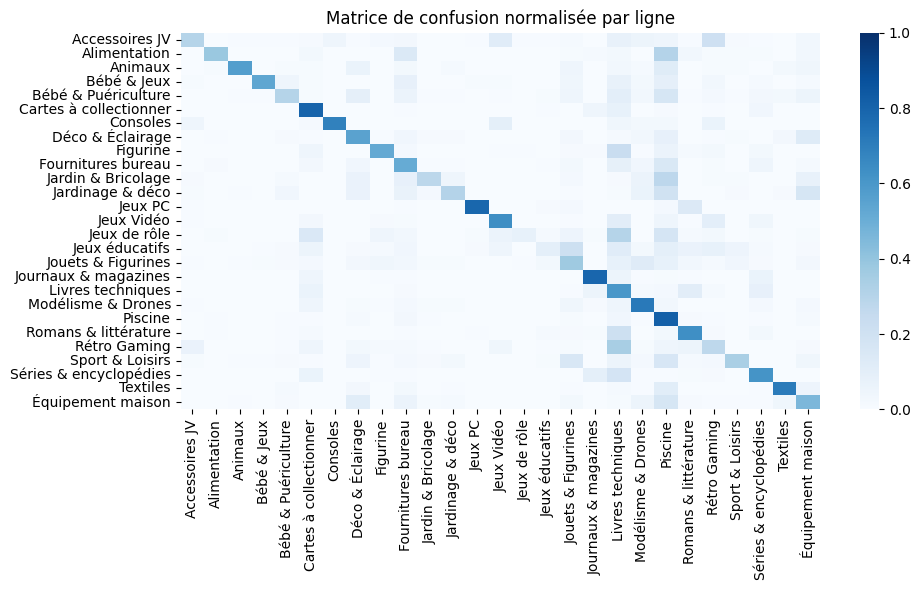

,precision,recall,f1-score,support
Accessoires JV,0.547,0.302,0.389,252.0
Livres techniques,0.223,0.604,0.325,467.0
Rétro Gaming,0.323,0.274,0.296,376.0
Jeux éducatifs,0.353,0.096,0.152,311.0
Jeux de rôle,0.450,0.078,0.133,115.0


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Rétro Gaming,Livres techniques,34.6
1,Alimentation,Piscine,30.8
2,Jeux de rôle,Livres techniques,30.4
3,Jardin & Bricolage,Piscine,27.8
4,Figurine,Livres techniques,23.4


In [15]:
y_pred = pipe.predict(X_test)
plot_classification_report(y_test, y_pred)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Le modèle atteint un <b>F1-score pondéré d’environ 0.55</b>, ce qui confirme la
pertinence des features textuelles explicites utilisées (mots-clés, unités et
longueurs de texte) pour une partie des catégories. Les meilleures performances
sont observées pour les classes disposant d’un <b>vocabulaire spécifique</b> et
de <b>signaux quantitatifs marqués</b>, telles que les catégories liées aux jeux
vidéo, aux cartes à collectionner ou aux produits techniques.
</p>

<p>
À l’inverse, les performances restent plus limitées pour les catégories dont le
<b>vocabulaire est partagé</b> ou peu distinctif, en particulier certaines
familles de produits culturels et ludiques. Les confusions observées montrent
que des descriptions longues ou riches en informations techniques tendent à être
sur-prédites dans quelques classes dominantes, traduisant les limites d’une
approche fondée exclusivement sur des signaux lexicaux explicites.
</p>

<p>
Dans l’ensemble, ces résultats mettent en évidence le <b>bon compromis entre
interprétabilité et performance</b> offert par ce modèle baseline, tout en
soulignant l’existence d’un <b>plafond de performance structurel</b> qui motive
le recours à des représentations textuelles plus riches dans les étapes
suivantes du projet.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>5 - Analyse des importances de features</h3>

<p>
Afin de mieux comprendre les mécanismes de décision du modèle, nous analysons
ci-dessous les <b>coefficients du modèle linéaire</b>. La matrice des
<b>coefficients absolus</b> permet d’identifier les features ayant l’influence la
plus marquée sur la prédiction de chaque catégorie, et d’évaluer le rôle relatif
des différentes familles de variables introduites dans le modèle.
</p>

</div>



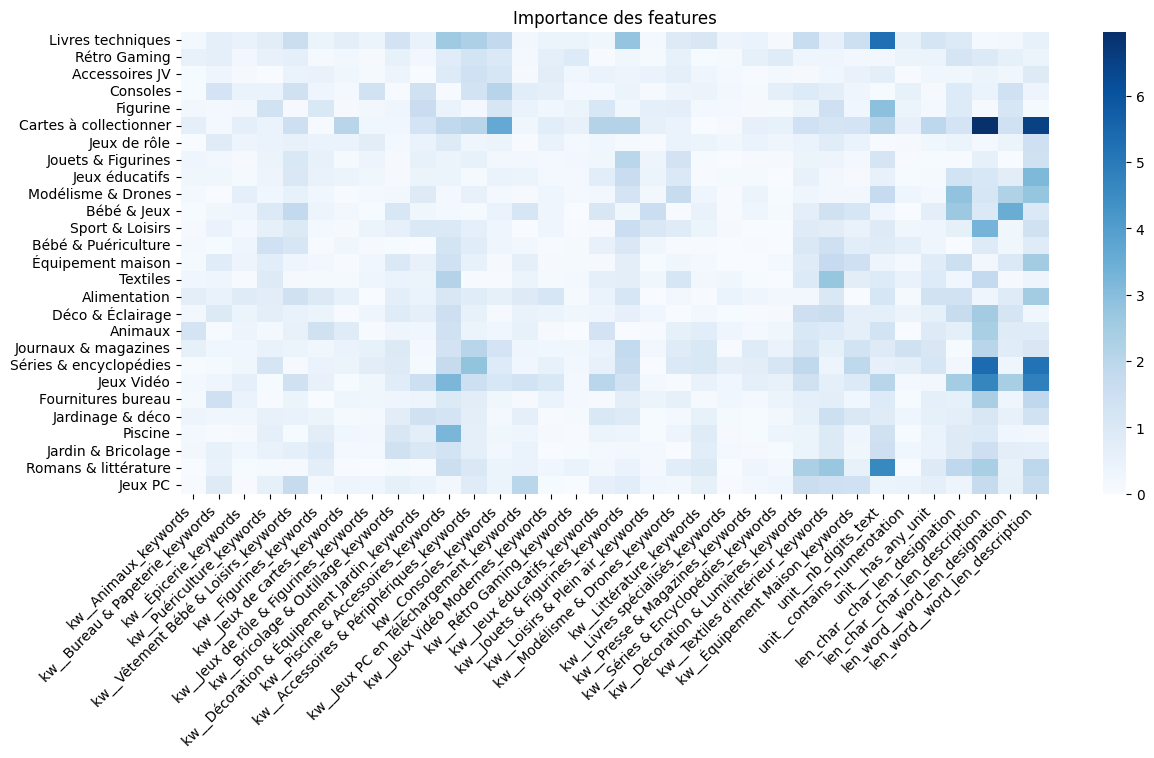

In [33]:
coef = pipe.named_steps['model'].coef_
feature_names = pipe.named_steps['features'].get_feature_names_out()

plot_features_importance(
    model_coef=coef,
    feature_spec=feature_names,
    classes=pipe.classes_
)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">
<p>
L’analyse de la matrice des coefficients absolus met en évidence le rôle central
des <b>features de mots-clés</b> dans la prise de décision du modèle. Pour de
nombreuses catégories, les coefficients associés aux mots-clés spécifiques
présentent les amplitudes les plus élevées, confirmant que le modèle s’appuie
principalement sur des signaux lexicaux explicites pour discriminer les classes.
</p>

<p>
Les features liées aux <b>unités et à la présence de numérotations</b> affichent
également des poids importants pour certaines catégories, traduisant leur forte
capacité discriminante dès lors que les descriptions contiennent des
informations quantitatives (dimensions, volumes, références, numéros).
</p>

<p>
Pour certaines catégories, l’analyse des coefficients permet d’expliquer plus
finement les performances observées. La classe <b>Livres techniques</b> présente
des coefficients élevés associés aux <b>features de longueur</b> (en particulier
la longueur de la description), ainsi qu’à plusieurs mots-clés génériques liés
au contenu éditorial. Ces signaux, bien que pertinents pour cette catégorie,
sont également partagés par d’autres familles de produits à descriptions longues
ou informatives, ce qui explique sa <b>sur-prédiction fréquente</b> et les
confusions observées.
</p>

<p>
À l’inverse, la catégorie <b>Piscine</b> est fortement caractérisée par des
coefficients très élevés sur les <b>features liées aux unités et aux
numérotations</b> (nombre de chiffres, présence d’unités). Cette dépendance à un
signal quantitatif fort explique à la fois son bon rappel et les confusions avec
des catégories techniques ou de bricolage partageant des descriptions riches en
dimensions ou volumes.
</p>

<p>
Enfin, la catégorie <b>Jeux de rôle</b> illustre les limites du modèle. Les
coefficients associés à ses mots-clés restent globalement faibles et peu
spécifiques, tandis que les features de structure ou d’unités n’apportent pas de
signal distinctif. Cette absence de marqueurs forts se traduit par un rappel très
faible et par des confusions systématiques avec des catégories culturellement
proches, notamment les livres.
</p>

<p>
Ces observations confirment que le modèle exploite efficacement les catégories
dotées de <b>signaux lexicaux ou quantitatifs clairs</b>, mais atteint ses limites
lorsque les classes reposent sur des distinctions principalement
<b>sémantiques</b>, difficilement capturables par des features explicites.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>6 - Conclusion</h3>

<p>
Ce notebook a permis de construire et d’analyser un <b>modèle baseline textuel</b>
fondé sur des features explicites et interprétables, issues de l’analyse
exploratoire des descriptions produits. L’utilisation conjointe de
<b>mots-clés</b>, de <b>caractéristiques quantitatives</b> (unités,
numérotations) et de <b>mesures de longueur de texte</b> conduit à une amélioration
progressive et cumulée des performances, avec un <code>F1-score pondéré</code>
d’environ <b>0.55</b>.
</p>

<p>
L’analyse des performances et des coefficients du modèle met en évidence que les
catégories disposant de <b>signaux lexicaux ou quantitatifs forts</b> sont bien
reconnues, tandis que les classes reposant sur des distinctions plus
<b>sémantiques</b> ou un vocabulaire partagé restent difficiles à séparer. Ces
résultats illustrent à la fois la <b>robustesse</b> et les <b>limites
structurelles</b> d’une approche fondée sur des règles lexicales manuelles.
</p>

<p>
Ce modèle constitue ainsi une <b>référence solide et interprétable</b> pour le
projet. Il fournit un point de comparaison clair pour les méthodes de
représentation textuelle plus riches qui seront explorées par la suite, telles
que la vectorisation automatique (TF-IDF) ou les embeddings contextuels, visant à
mieux capturer le contexte et la sémantique fine des descriptions produits.
</p>

</div>

